In [2]:
# Data manipulation
import pandas as pd
# Numerical operations
import numpy as np
# Data splitting and cross-validation
from sklearn.model_selection import train_test_split, StratifiedKFold
# Categorical label encoding
from sklearn.preprocessing import LabelEncoder
# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Word2Vec word embeddings
from gensim.models import Word2Vec
# Random number generation
import random
# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
# Data visualization
import matplotlib.pyplot as plt
# Progress bar
from tqdm import tqdm
# Regular expressions
import re
# Pre-trained transformer models
from transformers import BertTokenizer, BertForSequenceClassification, AdamW





C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd

# Function to map labels
def map_labels(label):
    if label == '__label__1':
        return '0'
    elif label == '__label__2':
        return '1'
    else:
        return label

# Read the first 50,000 lines from train.ft.txt
num_lines_to_read = 100000
lines_read = 0
data = []

with open('train.ft.txt', 'r', encoding='utf-8') as file:
    for line in file:
        if lines_read >= num_lines_to_read:
            break
        line = line.strip()
        if line.startswith('__label__'):
            label, text = line.split(' ', 1)
            label = map_labels(label)
            data.append([label, text])
            lines_read += 1

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Label', 'Text'])

# Save the DataFrame to a CSV file
df.to_csv('train.csv', index=False)

print("CSV file 'train.csv' created successfully.")


CSV file 'train.csv' created successfully.


In [4]:
df

,Label,Text
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
99995,1,Good: very good excelent fantastic wonderful m...
99996,0,THE REAL SUPERMAN: THESE ARE THE REAL ADVENTUR...
99997,0,It gets one star because zero was not an optio...
99998,0,Don't Spend Your Money: I think I now know mor...


In [5]:
df['Label'].unique()

array(['1', '0'], dtype=object)

(80000, 2) (10000, 2) (10000, 2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 2500/2500 [17:56:31<00:00, 25.84s/it]       


Epoch 1/3, Training Loss: 0.1725


Epoch 2/3: 100%|██████████| 2500/2500 [20:15:28<00:00, 29.17s/it]        


Epoch 2/3, Training Loss: 0.0941


Epoch 3/3: 100%|██████████| 2500/2500 [10:17:38<00:00, 14.82s/it]      


Epoch 3/3, Training Loss: 0.0525
Validation Accuracy: 0.9411
Validation Precision: 0.9417
Validation Recall: 0.9411
Validation F1 Score: 0.9410


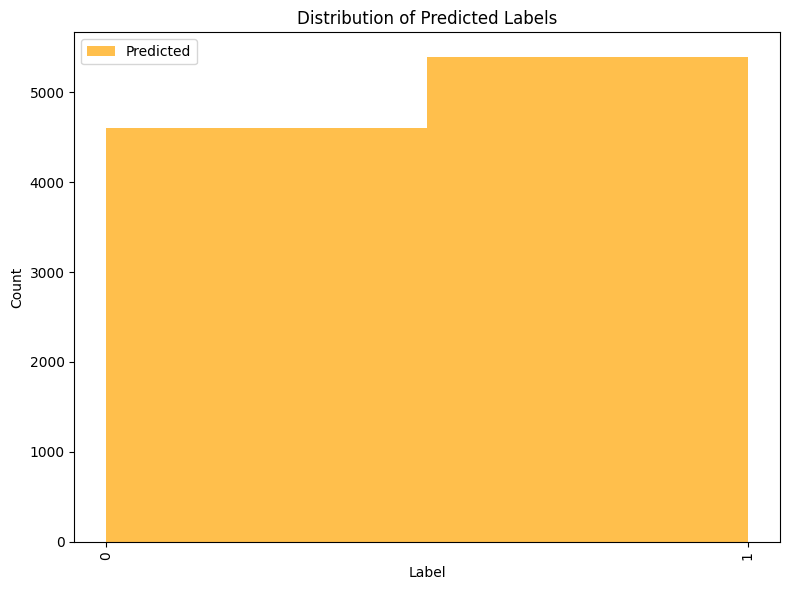

In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load and preprocess data
train_df = pd.read_csv('train.csv')

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(train_df.shape, val_df.shape, test_df.shape)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Create TensorDatasets for train, validation, and test
train_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(train_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(train_df['Label'].tolist())
)

val_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(val_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(val_df['Label'].tolist())
)

test_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(test_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(test_df['Label'].tolist())
)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {np.mean(train_losses):.4f}")

# Validation
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Inference on test data
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)

test_sentiments = label_encoder.inverse_transform(test_preds)

# Plot distribution of predicted labels
plt.figure(figsize=(8, 6))
plt.hist(test_sentiments, bins=len(label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:

class SentimentAnalyzer:
    def __init__(self, model_path='bert-base-uncased'):
        self.model_path = model_path
        self.tokenizer = None
        self.model = None
        self.label_encoder = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def initialize_model(self, train_df):
        # Load BERT tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(self.model_path)
        self.model = BertForSequenceClassification.from_pretrained(self.model_path, num_labels=len(self.label_encoder.classes_))

        # Create TensorDataset for training data
        train_dataset = TensorDataset(
            torch.tensor(self.tokenizer.batch_encode_plus(train_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
            torch.tensor(train_df['Label'].tolist())
        )

        # Define data loader for training
        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        # Set up model and optimizer
        self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5)
        self.criterion = torch.nn.CrossEntropyLoss()

    def train_model(self, num_epochs=3):
        self.model.train()
        for epoch in range(num_epochs):
            train_losses = []
            for batch in tqdm(self.train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
                input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids).logits
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                train_losses.append(loss.item())

            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {np.mean(train_losses):.4f}")

    def evaluate_model(self, val_loader):
        self.model.eval()
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids, labels = batch[0].to(self.device), batch[1].to(self.device)

                outputs = self.model(input_ids=input_ids).logits
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Precision: {val_precision:.4f}")
        print(f"Validation Recall: {val_recall:.4f}")
        print(f"Validation F1 Score: {val_f1:.4f}")

    def predict_sentiment(self, review):
        if self.tokenizer is None or self.model is None:
            raise ValueError("Model not initialized. Call 'initialize_model' first.")

        # Tokenize and prepare input
        input_text = [review]
        input_ids = torch.tensor(self.tokenizer.batch_encode_plus(input_text, padding='max_length', truncation=True, max_length=128)['input_ids']).to(self.device)

        # Inference
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids).logits
            pred = torch.argmax(outputs, dim=1).cpu().numpy()[0]

        # Map prediction to sentiment label
        sentiment_labels = {0: 'negative', 1: 'positive', 2: 'neither'}
        predicted_sentiment = sentiment_labels[pred]

        return predicted_sentiment



In [8]:
# # Create an instance of the SentimentAnalyzer class
# analyzer = SentimentAnalyzer()

# # Use the class for sentiment analysis
# review = "This is a positive review."
# predicted_sentiment = analyzer.predict_sentiment(review)
# print(f"Review: {review}")
# print(f"Predicted Sentiment: {predicted_sentiment}")

In [9]:
import torch

def predict_sentiment(sentence, model, tokenizer, label_encoder, device):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

    # Move the input tensors to the specified device (CPU or GPU)
    inputs.to(device)

    # Perform inference with the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (positive or negative)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Decode the predicted class using the label encoder
    predicted_sentiment = label_encoder.classes_[predicted_class]

    return predicted_sentiment

# Example usage:
sentence_to_predict = "This movie is really good!"
predicted_sentiment = predict_sentiment(sentence_to_predict, model, tokenizer, label_encoder, device)
print(f"Predicted Sentiment: {predicted_sentiment}")


Predicted Sentiment: 1


In [10]:
# Example sentences to predict sentiment
sentences_to_predict = [
    "I dont like the product",
    "I love the product",
    "I like the product",
    "I loved the movie, it was fantastic!",
    "This restaurant has terrible food and service.",
    "The weather today is absolutely beautiful.",
    "The customer support was outstanding.",
    "The book was quite disappointing.",
    "I had a great time at the party last night.",
    "The product is a waste of money.",
    "The concert was amazing, I had so much fun!",
]

for sentence in sentences_to_predict:
    predicted_sentiment = predict_sentiment(sentence, model, tokenizer, label_encoder, device)
    print(f"Sentence: '{sentence}'\nPredicted Sentiment: {predicted_sentiment}\n")


Sentence: 'I dont like the product'
Predicted Sentiment: 0

Sentence: 'I love the product'
Predicted Sentiment: 1

Sentence: 'I like the product'
Predicted Sentiment: 1

Sentence: 'I loved the movie, it was fantastic!'
Predicted Sentiment: 1

Sentence: 'This restaurant has terrible food and service.'
Predicted Sentiment: 0

Sentence: 'The weather today is absolutely beautiful.'
Predicted Sentiment: 1

Sentence: 'The customer support was outstanding.'
Predicted Sentiment: 1

Sentence: 'The book was quite disappointing.'
Predicted Sentiment: 0

Sentence: 'I had a great time at the party last night.'
Predicted Sentiment: 1

Sentence: 'The product is a waste of money.'
Predicted Sentiment: 0

Sentence: 'The concert was amazing, I had so much fun!'
Predicted Sentiment: 1



(80000, 2) (10000, 2) (10000, 2)


C:\Users\khans\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\khans\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were no

Epoch 1/3, Training Loss: 0.2336


Epoch 2/3: 100%|██████████| 2500/2500 [17:55:20<00:00, 25.81s/it]       


Epoch 2/3, Training Loss: 0.1440


Epoch 3/3: 100%|██████████| 2500/2500 [8:06:04<00:00, 11.67s/it]  


Epoch 3/3, Training Loss: 0.0993
Validation Accuracy: 0.9254
Validation Precision: 0.9254
Validation Recall: 0.9254
Validation F1 Score: 0.9254


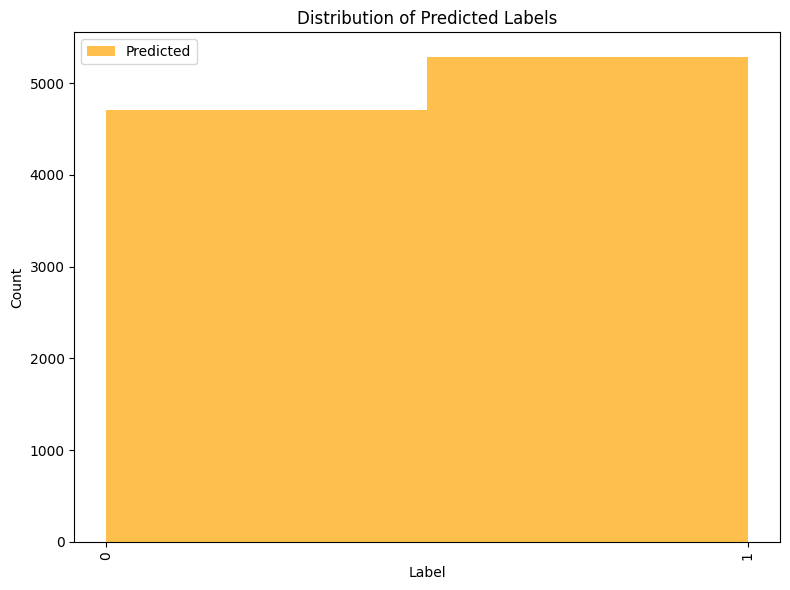

In [11]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load and preprocess data
train_df = pd.read_csv('train.csv')

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

print(train_df.shape, val_df.shape, test_df.shape)

# Load mBERT tokenizer and model (multilingual BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_encoder.classes_))

# Create TensorDatasets for train, validation, and test
train_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(train_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(train_df['Label'].tolist())
)

val_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(val_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(val_df['Label'].tolist())
)

test_dataset = TensorDataset(
    torch.tensor(tokenizer.batch_encode_plus(test_df['Text'].tolist(), padding='max_length', truncation=True, max_length=128)['input_ids']),
    torch.tensor(test_df['Label'].tolist())
)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Set up training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {np.mean(train_losses):.4f}")

# Validation
model.eval()
val_preds = []
val_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels.cpu().numpy())

val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Inference on test data
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, labels = batch[0].to(device), batch[1].to(device)

        outputs = model(input_ids=input_ids).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        test_preds.extend(preds)

test_sentiments = label_encoder.inverse_transform(test_preds)

# Plot distribution of predicted labels
plt.figure(figsize=(8, 6))
plt.hist(test_sentiments, bins=len(label_encoder.classes_), alpha=0.7, color='orange', label='Predicted')

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np

# Load the trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)  # Load your trained model here
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to predict sentiment for a list of reviews
def predict_sentiment(reviews, model, tokenizer):
    # Tokenize the reviews
    tokenized_reviews = tokenizer(reviews, padding=True, truncation=True, return_tensors='pt', max_length=128)

    # Make predictions
    with torch.no_grad():
        outputs = model(**tokenized_reviews)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

    return predicted_labels

# Example usage
if __name__ == '__main__':
    reviews = [
        "This product is excellent!",
        "Je n'aime pas du tout ce produit.",
        "Este producto es muy bueno."
    ]

    # Map the predicted labels back to sentiment categories
    label_map = {0: 'Negative', 1: 'Positive'}  # Adjust as per your label encoding
    predicted_labels = predict_sentiment(reviews, model, tokenizer)
    predicted_sentiments = [label_map[label] for label in predicted_labels]

    for review, sentiment in zip(reviews, predicted_sentiments):
        print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Review: This product is excellent!
Predicted Sentiment: Positive

Review: Je n'aime pas du tout ce produit.
Predicted Sentiment: Positive

Review: Este producto es muy bueno.
Predicted Sentiment: Positive

